#**Detecting Fake Reviews**

We will revisit this problem, seeing how sequence models can perform (perhaps they fare better than the simple unigram or bigram dense networks. Recall that this dataset is the product of research by a few folks in Computer Science: https://aclanthology.org/N13-1053.pdf. There is even a consumer-facing tool based on the model, here: http://reviewskeptic.com/. 

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

# Just load the data from the Week 3 folder again.
trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2022/main/Week%203/datasets/deceptive-opinion.csv')
trip_advisor = trip_advisor.sample(frac=1) # Shuffle the data since I'll eventually just use a simple validation split.

trip_advisor.describe(include='all')

,deceptive,hotel,polarity,source,text
count,1600,1600,1600,1600,1600
unique,2,20,2,3,1596
top,deceptive,swissotel,positive,MTurk,Very disappointed in our stay in Chicago Monoc...
freq,800,80,800,800,2


Let's set aside our labels...

In [4]:
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

Let's make a TextVectorization() layer to preprocess our text.

In [5]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # adding more tokens to allow for increase due to bigrams.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
)

text_vectorization.adapt(trip_advisor['text'])

Just to see what this layer is doing to our reviews... 

In [9]:
review_text = trip_advisor.loc[0,'text']
print(f'REVIEW TEXT: \n\n{review_text}')
review_len = len(review_text.split(' '))
print(f'REVIEW DETAILS: \n\nThe review contains roughly {review_len} words (based on white spaces).')
vectorized_review = text_vectorization(trip_advisor.loc[0,'text']).numpy()
print(f'It\'s vectorized form contains {vectorized_review.shape[0]} tokens.\n') #Including the start index.
print(f'VECTOR REPRESENTATION:\n')
vectorized_review # This text vectorization layer will convert a raw text vector into a sequence of integers.

REVIEW TEXT: 

We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... 

REVIEW DETAILS: 

The review contains roughly 106 words (based on white spaces).
It's vectorized form contains 105 tokens.

VECTOR REPRESENTATION:



array([  11,   48,   12,    5,   46,   58,  600,   19,  238,   24,    5,
       1899,    1,    1,  282,    9,    1,    7,    5,    1,    1,  119,
         13,  824,   19,    1, 1167,  274,    1,    1,    1,    3,    1,
        170,    3,  666,    1,  474,   26,    7,  483,   12,   53,  246,
          7,   29,  144,   33,  847,  999,   23,   66,   74,    1,    7,
        130,    7, 1166,    3,   45,    7,   29,   29,    1,   12,  472,
        465,    3,  472, 1558,   24,    5, 1455,  176,   69,  200,   32,
         20,   74,  100,   95, 1903,    8,    2,  139,  126,    7,   29,
         78,   41,   14,    7,  291,    2,  202,    6,   39,  325,    8,
          5,    1,    5,    1,    8,   25])

Before we proceed, do we expect a Sequence model to be helpful here (versus a bag of words model)? Recall, we should check the ratio of observations in training to mean number of tokens per sample. We don't expect to get much value at all from a sequential text model in this case, because we would need a much bigger dataset (on the order of 2.5 million observations). 

In [10]:
text = trip_advisor['text'].to_numpy()
print(f'The average review in our data has {np.mean(len(text))} words, and we have {len(trip_advisor)} samples.')

The average review in our data has 1600.0 words, and we have 1600 samples.


#*Model Using Bidirectional LSTM*

We will one-hot encode these integer sequences into sparse, binary vector sequences, i.e., whereas a particular review would have been a one dimensional vector of integers (one integer per word), now we will have a two-dimensional array, with one vector per word.  

In [11]:
one_hot_review = tf.one_hot(vectorized_review, depth=2000) # Depth is the longest sequence we might encounter - i.e., max tokens in a review.
print(one_hot_review.shape)

(105, 2000)


We will pass our integer sequences into a one-hot encoding layer, and from there into our Bidirectional LSTM.

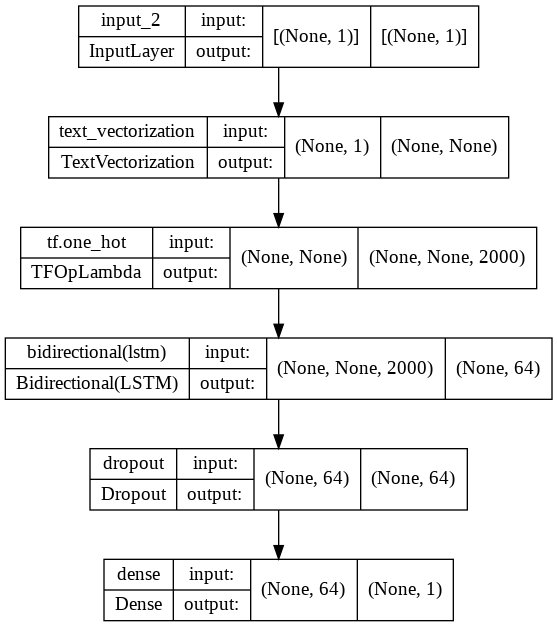

In [12]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=2000) # we one-hot encode those, so it becomes a length x2000 vector.
    x = layers.Bidirectional(layers.LSTM(32))(one_hot)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True)

Now we can train our model... 

In [7]:
text = np.array(trip_advisor['text'])
text = text.reshape(text.shape[0],1) # Note that I need to reshape this thing to explicitly state the second dimension, so Keras takes it.

data_train = text[:1200]
labels_train = label[:1200]
data_test = text[1200:]
labels_test = label[1200:]

Now we will fit our model with cross-validation again, as before... 

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 9s 104ms/step - loss: 0.6893 - accuracy: 0.5167 - val_loss: 0.6924 - val_accuracy: 0.4633
Epoch 2/25
24/24 [==============================] - 2s 71ms/step - loss: 0.6780 - accuracy: 0.5950 - val_loss: 0.6639 - val_accuracy: 0.5050
Epoch 3/25
24/24 [==============================] - 2s 65ms/step - loss: 0.6205 - accuracy: 0.7267 - val_loss: 0.6997 - val_accuracy: 0.5250
Epoch 4/25
24/24 [==============================] - 2s 72ms/step - loss: 0.5383 - accuracy: 0.8050 - val_loss: 0.5875 - val_accuracy: 0.7083
Epoch 5/25
24/24 [==============================] - 2s 72ms/step - loss: 0.4722 - accuracy: 0.8333 - val_loss: 0.5306 - val_accuracy: 0.7783
Epoch 6/25
24/24 [==============================] - 2s 71ms/step - loss: 0.3975 - accuracy: 0.8600 - val_loss: 0.5001 - val_accuracy: 0.7750
Epoch 7/25
24/24 [==============================] - 2s 72ms/step - loss: 0.3685 - accuracy: 0.8867 - val_loss: 0.6772 - val_accuracy: 0.7350
Epoch 8/25
2

Finally, plot loss / accuracy over training... wow, this model peaks at about the 3rd epoch! It learns much faster than our old model did, though it gets to about the same level of performance. 



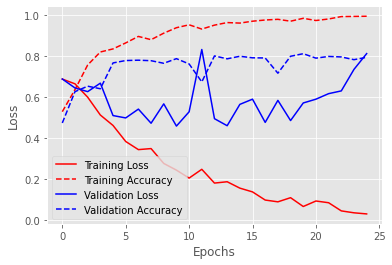

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

Let's see how we do on the holdout sample though. But wait! We dropped several features from the original dataset that we used last time. 

*Q: What could we do with those?*

In [ ]:
model = build_model()
model.fit(data_train,labels_train,epochs=4,batch_size=25)

test_acc = model.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/4
48/48 [==============================] - 6s 44ms/step - loss: 0.6812 - accuracy: 0.5892
Epoch 2/4
48/48 [==============================] - 2s 45ms/step - loss: 0.5785 - accuracy: 0.7375
Epoch 3/4
48/48 [==============================] - 2s 42ms/step - loss: 0.4549 - accuracy: 0.8358
Epoch 4/4
13/13 [==============================] - 1s 24ms/step - loss: 0.3891 - accuracy: 0.8500
The resulting model is about 85.00% accurate in the holdout sample.


#*Textual Embeddings*

We can pre-process the text using an Embedding layer, before going to LSTM, to 'help the model along.' The Embedding layer will be of shape Vocabular-Size x Vector Length (dimensionality of the latent space). We can feed these sequences of vectors into our LSTM. 

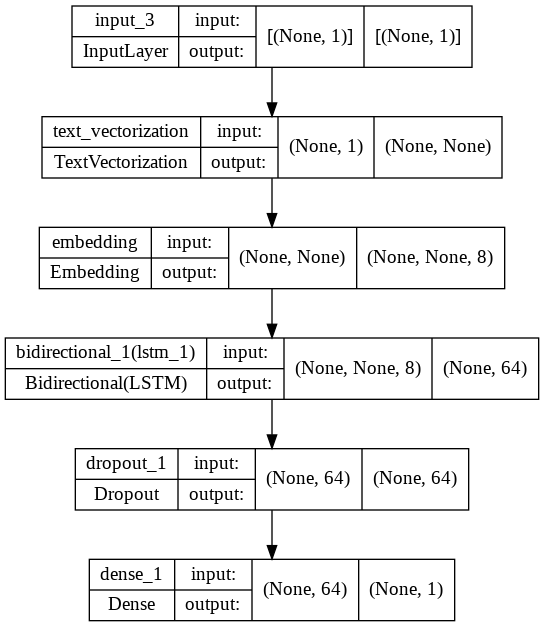

In [14]:
def build_model_embed():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    # Truncates after 600 tokens, and pads up to 600 tokens for shorter reviews.
    # Mask zero means it will skip 0 tokens and will not pass them on.
    embedding = keras.layers.Embedding(input_dim=2000,output_dim=8,input_length=600, mask_zero=True)(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_embed = build_model_embed()

keras.utils.plot_model(model_embed, show_shapes=True)

Fit the model again... 

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_embed()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 [==============================] - 10s 162ms/step - loss: 0.6909 - accuracy: 0.5567 - val_loss: 0.6944 - val_accuracy: 0.4633
Epoch 2/25
24/24 [==============================] - 1s 60ms/step - loss: 0.6809 - accuracy: 0.5517 - val_loss: 0.6728 - val_accuracy: 0.6033
Epoch 3/25
24/24 [==============================] - 1s 45ms/step - loss: 0.5692 - accuracy: 0.7333 - val_loss: 0.7207 - val_accuracy: 0.6567
Epoch 4/25
24/24 [==============================] - 1s 45ms/step - loss: 0.4807 - accuracy: 0.7783 - val_loss: 0.4588 - val_accuracy: 0.8117
Epoch 5/25
24/24 [==============================] - 1s 46ms/step - loss: 0.3643 - accuracy: 0.8533 - val_loss: 0.5893 - val_accuracy: 0.6883
Epoch 6/25
24/24 [==============================] - 1s 45ms/step - loss: 0.3902 - accuracy: 0.8333 - val_loss: 0.4475 - val_accuracy: 0.8067
Epoch 7/25
24/24 [==============================] - 1s 45ms/step - loss: 0.2915 - accuracy: 0.8967 - val_loss: 0.5370 - val_accuracy: 0.7683
Epoch 8/25


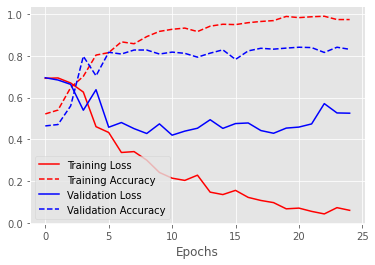

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

And we evaluate again on the test data... the custom embedding layer actually does not help us in this case!

In [ ]:
model_embed = build_model_embed()
model_embed.fit(data_train,labels_train,epochs=8,batch_size=25)

test_acc = model.evaluate(data_test,labels_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/8
48/48 [==============================] - 9s 31ms/step - loss: 0.6901 - accuracy: 0.5375
Epoch 2/8
48/48 [==============================] - 1s 30ms/step - loss: 0.5911 - accuracy: 0.7108
Epoch 3/8
48/48 [==============================] - 1s 31ms/step - loss: 0.4185 - accuracy: 0.8217
Epoch 4/8
48/48 [==============================] - 1s 31ms/step - loss: 0.3581 - accuracy: 0.8650
Epoch 5/8
48/48 [==============================] - 1s 31ms/step - loss: 0.3158 - accuracy: 0.8742
Epoch 6/8
48/48 [==============================] - 1s 31ms/step - loss: 0.2690 - accuracy: 0.9017
Epoch 7/8
48/48 [==============================] - 1s 31ms/step - loss: 0.2370 - accuracy: 0.9133
Epoch 8/8
13/13 [==============================] - 0s 16ms/step - loss: 0.4806 - accuracy: 0.8275
The resulting model is about 82.75% accurate in the holdout sample.


#*GloVe Embeddings*

Let's see if we can use pre-trained GloVe embeddings to do better here. We will download the GloVe pre-trained embeddings (these are pre-trained embeddings from Wikipedia page data collected in 2014, as well as newswire data). Note that there are also GloVe embeddings that were trained from Twitter, which might be more appropriate for social media data: https://nlp.stanford.edu/projects/glove/

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-02-25 18:19:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-25 18:19:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-25 18:19:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Note that there are about 1.2 million words in the English language. GloVe contains embeddings for about one third of those words (but that is going to cover most words you will encounter in regular usage!).

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt" 
  
embeddings_index = {} 
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # Split off only the first element in the row, i.e., the word, keep the remaining values as the vector.
        coefs = np.fromstring(coefs, "f", sep=" ") # Convert the set of numeric values into a numpy array, splitting elements by ' '
        embeddings_index[word] = coefs # Populate our dictionary - for this word (key), the vector representation is this vector (value).
  
glove_vec_lengths = len(coefs)

print(f"Found {len(embeddings_index)} word vectors.")
print(f"GloVe vector representations are {glove_vec_lengths} elements long.")

Found 400000 word vectors.
GloVe vector representations are 100 elements long.


We will now construct the Embedding matrix. This is the mapping between word tokens (integer indices) in our data and their vector representations.

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
print(f"Recall that our vocabulary has {len(vocabulary)} tokens in it.")
print(f"Here is the 11th word in our vocabulary: {vocabulary[13]}.") # Recall that the first two indices are reserved for 'padding' and 'UNK'

Recall that our vocabulary has 2000 tokens in it.
Here is the 11th word in our vocabulary: room.


In [ ]:
embedding_dim = glove_vec_lengths # The length of the vector representations; the latent embedding space will be in 100 dimensions. 

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.

# Instantiate a matrix of values (these will be the 'weights' in our embedding layer)
embedding_matrix = np.zeros((len(vocabulary), embedding_dim)) # It will be the 2000 tokens by 100 (length of GloVe vectors)
for word, i in word_index.items():
    if i < len(vocabulary):
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Here is the GloVe vector embedding for 'room'
embedding_matrix[13]

array([-0.024843  ,  0.47766   ,  0.32437   , -0.054239  , -0.47622001,
        1.10430002,  0.014733  ,  0.92413002, -0.0036772 , -0.29596999,
        0.54781997, -0.081146  , -0.021779  ,  0.51880002,  0.14273   ,
       -0.019756  , -0.4429    ,  0.45526001, -0.34454   , -0.81260002,
       -0.35356   ,  0.019425  , -0.26789001, -1.06159997,  0.27105001,
       -0.70291001, -0.14556   , -0.46669   , -0.38155001, -0.11217   ,
        0.14527   ,  0.047139  ,  0.076051  ,  0.64837998, -0.051128  ,
        1.01119995, -0.40836999,  0.34013   ,  0.75625998, -0.70703   ,
        0.23114   , -1.01240003,  0.16597   , -0.33013001,  0.43122   ,
        0.12475   , -0.87905997,  0.45133001,  0.74589002, -0.52077001,
        0.062784  , -0.55373001, -0.17152999,  1.02119994, -0.020486  ,
       -3.03209996, -0.26379001, -0.41382   ,  1.19669998,  0.45789999,
       -0.37781   ,  0.85339999,  0.15135001,  0.28586   , -0.04119   ,
       -0.057052  ,  1.32219994, -0.17764001, -0.21249001, -0.06

Now we use those vector representations to instantiate our Embedding layer. Rather than 'learning' the Embedding layer's weights, we will fix the weights to be the GloVe embeddings, and make them non-trainable. 

In [ ]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    glove_vec_lengths, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

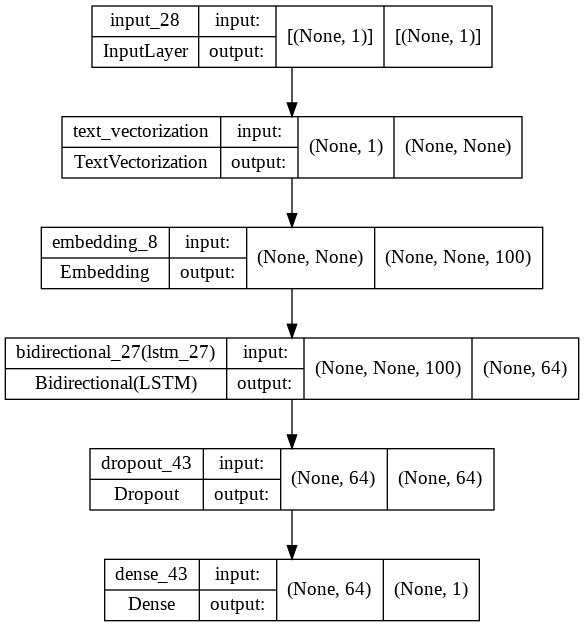

In [ ]:
def build_model_GloVe():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    embedding = embedding_layer(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_GloVe = build_model_GloVe()

keras.utils.plot_model(model_GloVe, show_shapes=True)

And, once again, let's cross validate... 

In [ ]:
k = 3
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_GloVe()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
32/32 [==============================] - 11s 120ms/step - loss: 0.6909 - accuracy: 0.5612 - val_loss: 0.6375 - val_accuracy: 0.6925
Epoch 2/25
32/32 [==============================] - 1s 42ms/step - loss: 0.6066 - accuracy: 0.6650 - val_loss: 0.5833 - val_accuracy: 0.6950
Epoch 3/25
32/32 [==============================] - 1s 39ms/step - loss: 0.5408 - accuracy: 0.7375 - val_loss: 0.5910 - val_accuracy: 0.6875
Epoch 4/25
32/32 [==============================] - 1s 41ms/step - loss: 0.4848 - accuracy: 0.7688 - val_loss: 0.6508 - val_accuracy: 0.7000
Epoch 5/25
32/32 [==============================] - 1s 41ms/step - loss: 0.4779 - accuracy: 0.7788 - val_loss: 0.5292 - val_accuracy: 0.7175
Epoch 6/25
32/32 [==============================] - 1s 39ms/step - loss: 0.4559 - accuracy: 0.7900 - val_loss: 0.5728 - val_accuracy: 0.6925
Epoch 7/25
32/32 [==============================] - 1s 39ms/step - loss: 0.4284 - accuracy: 0.8025 - val_loss: 0.5124 - val_accuracy: 0.7625
Epoch 8/25


Plotting average loss over training once again... 

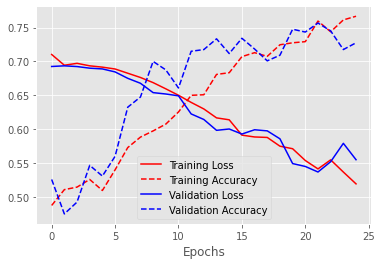

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

#*Word2Vec Embeddings*

Now we will try out the word2vec pre-trained embeddings (from Wikipedia). Let's download the English language, Wikipedia 100-dimensional embeddings. Note that this can take some time because the embedding file is large. 

In [15]:
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
!bzip2 -d enwiki_20180420_100d.pkl.bz2

--2022-02-27 17:37:20--  http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
Resolving wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)... 52.219.68.117
Connecting to wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)|52.219.68.117|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3514838671 (3.3G) [application/x-bzip2]
Saving to: ‘enwiki_20180420_100d.pkl.bz2’

enwiki_20180420_100 100%[===================>]   3.27G  19.3MB/s    in 2m 58s  

2022-02-27 17:40:19 (18.8 MB/s) - ‘enwiki_20180420_100d.pkl.bz2’ saved [3514838671/3514838671]



Now let's create an embedding matrix, as before, etc. Note, we can see that most of the words for which we lack embeddings are actually typos or proper nouns. We could manually fix the typos, or not (perhaps the typos are indicative of deceipt!

In [19]:
try:
  from wikipedia2vec import Wikipedia2Vec
except ImportError as error:
  !pip install wikipedia2vec
  from wikipedia2vec import Wikipedia2Vec

from wikipedia2vec import Wikipedia2Vec

# These embeddings are 100 dimensional also.
embedding_dim = 100

wiki2vec = Wikipedia2Vec.load('enwiki_20180420_100d.pkl')

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

for word, index in word_index.items():
    try:
        embedding_matrix[index] = wiki2vec.get_word_vector(f'{word}')
    except:
        print(f'Skipping {word}, no embedding for it.')
        continue

print(f'The embedding for \'room\' is {embedding_matrix[15]}.')

Skipping , no embedding for it.
Skipping [UNK], no embedding for it.
Skipping werent, no embedding for it.
Skipping inroom, no embedding for it.
Skipping hadnt, no embedding for it.
Skipping definately, no embedding for it.
Skipping shouldnt, no embedding for it.
Skipping accomodating, no embedding for it.
Skipping ohare, no embedding for it.
Skipping accomodations, no embedding for it.
Skipping definetly, no embedding for it.
Skipping shulas, no embedding for it.
The embedding for 'room' is [-0.04475478  0.52349627  0.15551241  0.13616104  0.00284019 -0.08661265
  0.05645907 -0.20347282  0.02514262 -0.50536108 -0.38650605 -0.0852759
  0.29945976 -0.11940839 -0.06857705 -0.17449841  0.2246068   0.13887054
  0.15167743  0.17579257  0.04217658 -0.10980772  0.09993367  0.01266596
 -0.20744962 -0.50846672  0.27036953 -0.18056074 -0.01523099  0.32400358
  0.19859086 -0.16741541 -0.17544943 -0.2759535  -0.40312016 -0.3360047
 -0.26442048 -0.25339603  0.28910047 -0.36898452  0.09097765 -0.053

And, again, let's make our embedding layer... 

In [20]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    100, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

And we instantiate the model again... 

In [ ]:
def build_model_word2vec():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    
    embedding = embedding_layer(processing)
    
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_word2vec = build_model_word2vec()

And, let's fit the model one last time... once again, these don't help! The embeddings actually hurt. 

In [ ]:
k = 3
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_word2vec()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
32/32 [==============================] - 23s 113ms/step - loss: 0.6936 - accuracy: 0.5225 - val_loss: 0.6634 - val_accuracy: 0.6425
Epoch 2/25
32/32 [==============================] - 1s 41ms/step - loss: 0.6388 - accuracy: 0.6313 - val_loss: 0.6151 - val_accuracy: 0.6950
Epoch 3/25
32/32 [==============================] - 1s 37ms/step - loss: 0.5614 - accuracy: 0.7188 - val_loss: 0.6032 - val_accuracy: 0.6750
Epoch 4/25
32/32 [==============================] - 1s 37ms/step - loss: 0.5203 - accuracy: 0.7513 - val_loss: 0.5384 - val_accuracy: 0.7425
Epoch 5/25
32/32 [==============================] - 1s 37ms/step - loss: 0.4888 - accuracy: 0.7550 - val_loss: 0.5495 - val_accuracy: 0.7375
Epoch 6/25
32/32 [==============================] - 1s 40ms/step - loss: 0.4711 - accuracy: 0.7625 - val_loss: 0.5464 - val_accuracy: 0.7250
Epoch 7/25
32/32 [==============================] - 1s 39ms/step - loss: 0.4455 - accuracy: 0.7937 - val_loss: 0.5271 - val_accuracy: 0.7375
Epoch 8/25


Plotting average model loss / accuracy across folds, over training.

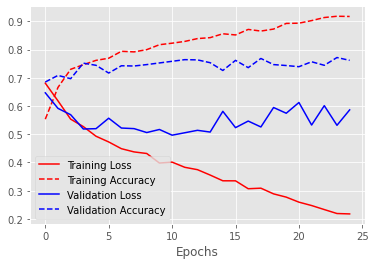

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()